# LNMMSB

In [ ]:
import os 
import sys
import jax
import jax.numpy as jnp
from jax.nn import softmax

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.plots import plot_roles, plot_adjacency_matrix
from utils.utils import compute_best_permutation, l1_loss

from models.LNMMSB import jitLNMMSB

## Generation

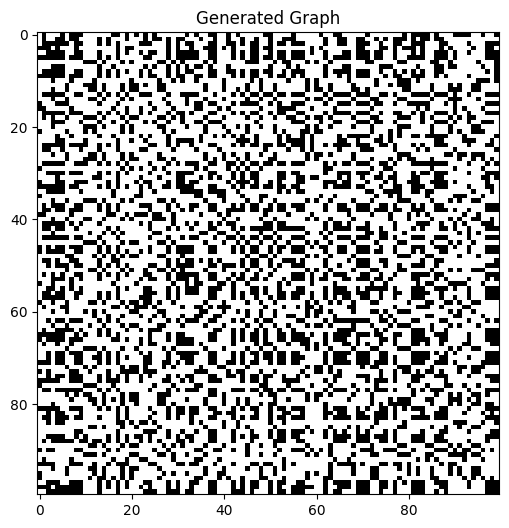

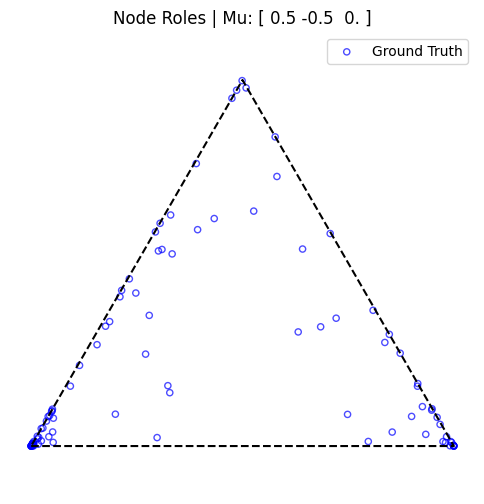

In [12]:
N = 100
K = 3

B = jnp.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])
Sigma = jnp.eye(K-1)*20
mu = jnp.array([0.5, -0.5])


# plt.imshow(E)
# plt.show()

#print(gammas)
    
gen_model = jitLNMMSB(N, K, key=42, B=B, mu=mu, Sigma=Sigma)
E = gen_model.generate_graph()
plot_adjacency_matrix(E, title="Generated Graph")
expanded_gamma = jnp.concatenate([gen_model.gamma_tilde, jnp.zeros((gen_model.N, 1))], axis=-1) # shape (T,N,K)
expanded_mu = jnp.concatenate([gen_model.mu, jnp.zeros((1,))], axis=-1) # shape (,K)
pis = softmax(expanded_gamma, axis=-1)
jnp.set_printoptions(precision=2, suppress=True)
plot_roles(pis, title=f"Node Roles | Mu: {expanded_mu}")

# Inference

In [13]:
restarts = 5

best_model = None
best_ll = -jnp.inf
for run in range(restarts):
    print(f"Run {run+1}")

    model = jitLNMMSB(nodes=100, roles=3, key=10+run)
    ll = model.fit(E, max_inner_iters=1000, max_outer_iters=50, tol=1e-6, verbose=True)

    if ll > best_ll:
        best_ll = ll
        best_model = model
    print(f"Current ll:{ll} | Best ll:{best_ll}")


Run 1
Current ll:-0.11911767721176147 | Best ll:-0.11911767721176147
Run 2
Current ll:-0.11877228319644928 | Best ll:-0.11877228319644928
Run 3
Current ll:-1804.7906494140625 | Best ll:-0.11877228319644928
Run 4
Current ll:-0.11897000670433044 | Best ll:-0.11877228319644928
Run 5
Current ll:-1120.273681640625 | Best ll:-0.11877228319644928


### Role Matrix Recovery

In [14]:
jnp.set_printoptions(precision=3, suppress=True)
print("Best Model Role Matrix:")
print(best_model.B)
print("Ground Truth Role Matrix:")
print(B)


Best Model Role Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Ground Truth Role Matrix:
[[1 0 0]
 [0 1 0]
 [0 0 1]]


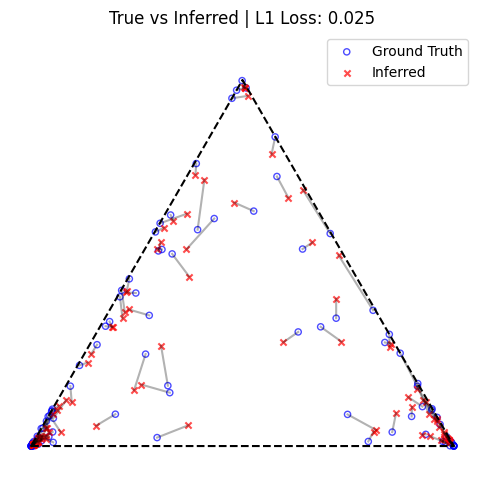

In [17]:
inferred_gammas = jnp.concatenate([best_model.gamma_tilde, jnp.zeros((best_model.N, 1))], axis=-1) # shape (N,K
true_gammas = jnp.concatenate([gen_model.gamma_tilde, jnp.zeros((model.N, 1))], axis=-1) # shape (N,K)

inferred_roles = softmax(inferred_gammas, axis=-1)
true_roles = softmax(true_gammas, axis=-1)

perm = compute_best_permutation(true_roles, inferred_roles)
plot_roles(true_roles, inferred_roles[:, perm], title=f"True vs Inferred | L1 Loss: {l1_loss(true_roles, inferred_roles[:, perm]):.3f}")